https://www.kaggle.com/erikbruin/house-prices-lasso-xgboost-and-a-detailed-eda
 
1 Executive Summary  
2 Introduction  
## 3 Loading and Exploring Data  
### 3.1 Loading libraries required and reading the data into R  
- train
- test
### 3.2 Data size and structure  
- shape
- type
- Null portion
## 4 Exploring some of the most important variables  
### 4.1 The response variable; SalePrice 
- Y 데이터 분포 확인 (skewed?)
- Y.info(), Y.summary()
### 4.2 The most important numeric predictors  
#### 4.2.1 Correlations with SalePrice  
- numeric X 변수 & Y 변수 상관관계
#### 4.2.2 Overall Quality  
- 상관관계가 높은 X변수와 Y변수 Outlier 확인
- outlier가 제거한 뒤 Y값과 상관도와 제거전 상관도 비교
#### 4.2.3 Above Grade (Ground) Living Area (square feet)  
- 상관관계가 높은 X변수와 Y변수 Outlier 확인
- outlier로 의심되는 부분이 있으면 상관관계가 높은 다른 x변수 확인  
## 5 Missing data, label encoding, and factorizing variables  
### 5.1 Completeness of the data  
- 결측 비율 확인
### 5.2 Imputing missing data  
- NA 가 'None'
- Mean, Median
- Binding mean
### 5.3 Label encoding/factorizing the remaining character variables
- Label Encoding 후 mapping되는 값 확인
### 5.4 Changing some numeric variables into factors
- Num으로 되어있지만 사실 cat인 변수 변환
5.4.1 Year and Month Sold  
5.4.2 MSSubClass  
## 6 Visualization of important variables
- 몇 개가 cat? 몇 개가 num?
### 6.1 Correlations again
- missing value 채운 뒤 다시 num X-변수 & Y-변수 상관관계
### 6.2 Finding variable importance with a quick Random Forest
- cat + num 다 포함해서 변수 중요도를 보고 싶음
- 가장 simple and quick 한 RF 이용해서 중요도 파악
#### 6.2.1 Above Ground Living Area, and other surface related variables (in square feet)  
- 각 변수들 count
6.2.2 The most important categorical variable; Neighborhood  
6.2.3 Overall Quality, and other Quality variables   
6.2.4 The second most important categorical variable; MSSubClass  
6.2.5 Garage variables  
6.2.6 Basement variables  
## 7 Feature engineering
### 7.1 Total number of Bathrooms
- 중요도가 낮지만 상관성이 높은 변수들 3개 => 1개로 바꾸기
- 바꾼 변수로 상관도 확인. 높아졌나?
### 7.2 Adding ‘House Age’, ‘Remodeled (Yes/No)’, and IsNew variables
- 리모델링 날짜 유/무 -> 리모델 유/무 변수 생성, 상관도 확인
7.3 Binning Neighborhood  
7.4 Total Square Feet  
7.5 Consolidating Porch variables  
## 8 Preparing data for modeling
### 8.1 Dropping highly correlated variables
- 두 X변수간의 상관관계가 너무 높은 경우에 Y값과 상관도가 조금이라도 낮은 X변수를 drop
-  For instance: GarageCars and GarageArea have a correlation of 0.89. Of those two. GarageArea drop : SalePrice 상관도 0.62. GarageCars 상관도 0.64
### 8.2 Removing outliers
### 8.3 PreProcessing predictor variables
#### 8.3.1 Skewness and normalizing of the numeric predictors
- 왜도가 0.8 초과하는 Numeric X 변수는 log변환으로 정규성 맞추기
#### 8.3.2 One hot encoding the categorical variables
- k-1개 one-hot 해서 모든 변수를 numeric으로
#### 8.3.3 Removing levels with few or no observations in train or test
- 결측 너무 많은 경우 train, test 모두 결측 많은 지 보고 drop
### 8.4 Dealing with skewness of response variable
- Y변수 Q-Q plot으로 정규성 확인
- 비정규인 경우 log변환
### 8.5 Composing train and test sets
## 9 Modeling
### 9.1 Lasso regression model
- 이왕이면 ridge, lasso, elastic net 다 해보고 제일 좋은 거로 선택
- grid search 로 최적의 lambda 찾기
- lasso에서 선택된 변수들을 포함하기 전, 포함 후 정확도 비교
### 9.2 XGBoost model
### 9.3 Compare model accuracy and choose one

In [120]:
# Default
import os
import time
from IPython import display 
import warnings
warnings.filterwarnings('ignore')

# preprocessing or statistics
import numpy as np
import pandas as pd
from scipy import stats
from scipy.stats import norm, skew #for some statistics
from datetime import datetime, timedelta

# Visualisation
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import seaborn as sns
sns.set(style='white')
sns.set(style='whitegrid', color_codes=True)

# machine learning
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, RFECV, SelectFromModel
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

# model evaluation
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import metrics
from sklearn.metrics import log_loss

In [2]:
df_train = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')
df_test = pd.read_csv('../data/house-prices-advanced-regression-techniques/test.csv')

https://www.kaggle.com/dejavu23/house-prices-eda-to-ml-beginner

add)
https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard/output

In [3]:
def get_best_score(grid):
    
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)    
    print(grid.best_params_)
    print(grid.best_estimator_)
    
    return best_score

In [4]:
print(df_train.shape)
print(df_test.shape)

(1460, 81)
(1459, 80)


In [5]:
# df_train.head(), df_train.describe()

## Y변수 분포

Skewness: 1.882876
Kurtosis: 6.536282


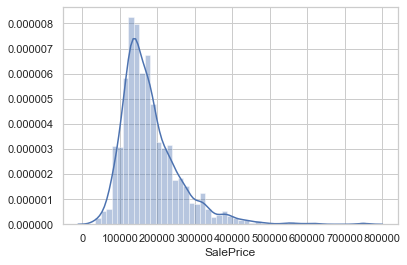

In [6]:
sns.distplot(df_train['SalePrice']);
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 0.121335
Kurtosis: 0.809532


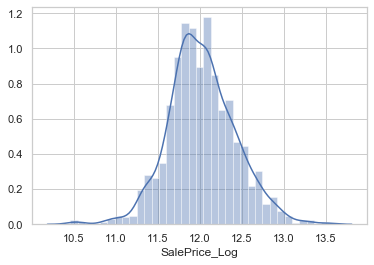

In [7]:
df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])
# train["SalePrice"] = np.log1p(train["SalePrice"])

sns.distplot(df_train['SalePrice_Log']);
# skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice_Log'].skew())
print("Kurtosis: %f" % df_train['SalePrice_Log'].kurt())
# dropping old column
df_train.drop('SalePrice', axis= 1, inplace=True)

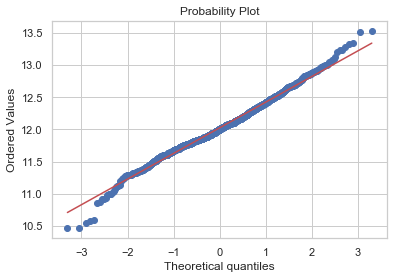

In [118]:
#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['SalePrice_Log'], plot=plt)
plt.show()

In [121]:
(mu, sigma) = norm.fit(train['SalePrice'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))


 mu = 180932.92 and sigma = 79467.79



In [8]:
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index
print("Number of Numerical features: ", len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == "object"].index
print("Number of Categorical features: ", len(categorical_feats))

Number of Numerical features:  38
Number of Categorical features:  43


## Missing data 테이블

In [9]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


In [10]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)

In [11]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
SalePrice_Log,0,0.000000
ExterCond,0,0.000000


In [12]:
# fillna with mean for the remaining columns: LotFrontage, GarageYrBlt, MasVnrArea
df_train.fillna(df_train.mean(), inplace=True)
df_test.fillna(df_test.mean(), inplace=True)

In [13]:
# 너무 많아서 우선 생략
for col in numerical_feats[:4]:
    print('{:15}'.format(col), 
          'Skewness: {:05.2f}'.format(df_train[col].skew()) , '   ' ,
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt()))

Id              Skewness: 00.00     Kurtosis: -01.20
MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.38     Kurtosis: 021.85
LotArea         Skewness: 12.21     Kurtosis: 203.24


Skewness: 1.366560
Kurtosis: 4.895121


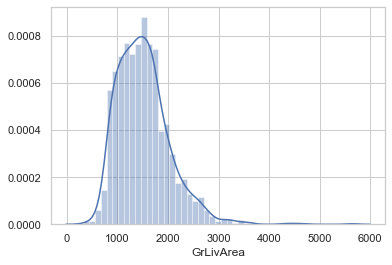

In [14]:
### 추가로 다른 변수들 왜도 파악
sns.distplot(df_train['GrLivArea']);
#skewness and kurtosis
print("Skewness: %f" % df_train['GrLivArea'].skew())
print("Kurtosis: %f" % df_train['GrLivArea'].kurt())

In [15]:
for df in [df_train, df_test]:
    df['GrLivArea_Log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace= True, axis = 1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace= True, axis = 1)
    
numerical_feats = df_train.dtypes[df_train.dtypes != "object"].index

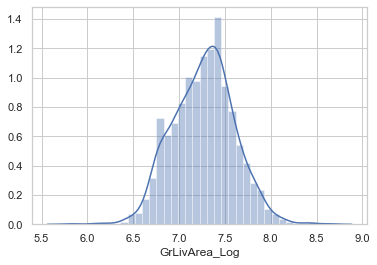

In [16]:
sns.distplot(df_train['GrLivArea_Log']);

### +) Box_ Cox Transformation

In [ ]:
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    all_data[feat] = boxcox1p(all_data[feat], lam)

## Outliers

### +) Add

In [113]:
train = pd.read_csv('../data/house-prices-advanced-regression-techniques/train.csv')

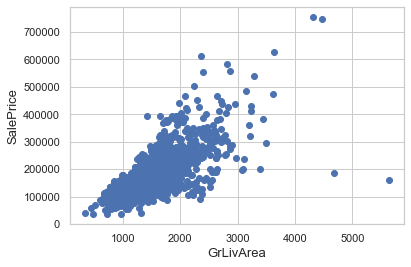

In [114]:
fig, ax = plt.subplots()
ax.scatter(x = train['GrLivArea'], y = train['SalePrice'])
plt.ylabel('SalePrice', fontsize=13)
plt.xlabel('GrLivArea', fontsize=13)
plt.show()

In [115]:
#Deleting outliers
train = train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

---

In [17]:
df_train = df_train.drop(
    df_train[(df_train['OverallQual']==10) & (df_train['SalePrice_Log']<12.3)].index)

In [18]:
df_train = df_train.drop(
    df_train[(df_train['GrLivArea_Log']>8.3) & (df_train['SalePrice_Log']<12.5)].index)

In [19]:
target = 'SalePrice_Log'

### Y변수와 X변수 간 상관관계 파악

In [20]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

In [21]:
ser_corr.head()

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
GarageCars       0.681033
GarageArea       0.656128
Name: SalePrice_Log, dtype: float64

In [22]:
min_val_corr = 0.4

In [23]:
cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

In [24]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]

### Correlation matrix

In [25]:
nr_feats = len(cols_abv_corr_limit)
nr_c = nr_feats

corr = df_train.corr()
corr_abs = corr.abs()
cols = corr_abs.nlargest(nr_feats, target)[target].index
cm = np.corrcoef(df_train[cols].values.T)

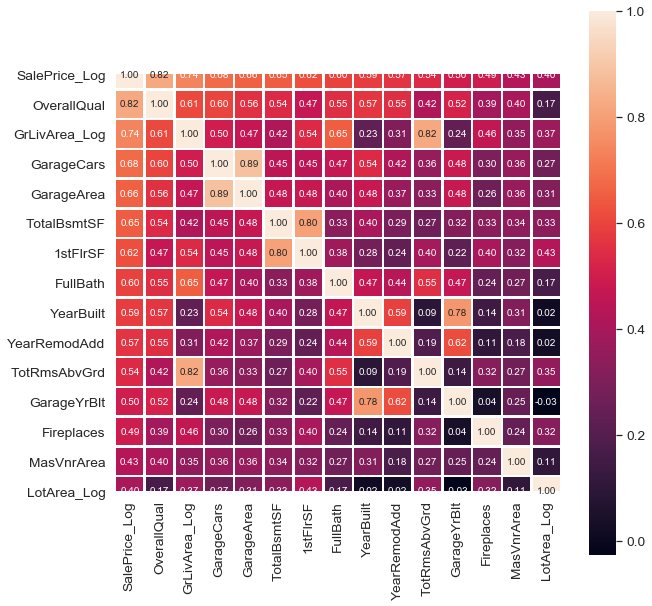

In [26]:
plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
sns.set(font_scale=1.25)
sns.heatmap(cm, linewidths=1.5, annot=True, square=True, 
            fmt='.2f', annot_kws={'size': 10}, 
            yticklabels=cols.values, xticklabels=cols.values)
plt.show()

Y 변수와 높은 상관성을 보이면서, 서로 연관성이 높은 다중공선성을 띄는 변수 존재

In [27]:
id_test = df_test['Id']
to_drop_num  = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg 

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace= True, axis = 1)

## Conver num -> Cat

In [ ]:
#MSSubClass=The building class
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)
#Changing OverallCond into a categorical variable
all_data['OverallCond'] = all_data['OverallCond'].astype(str)
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

## Convert Cat -> num

In [28]:
# catg_list = catg_strong_corr.copy()
# catg_list.remove('Neighborhood')
# for catg in catg_list[:2] :
#     sns.violinplot(x=catg, y=target, data=df_train)
#     plt.show()

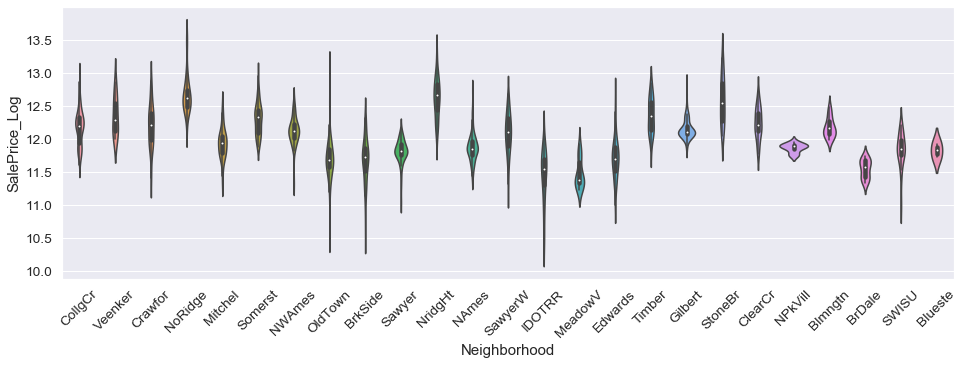

In [29]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='Neighborhood', y=target, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [30]:
# 'MSZoning'
msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV'] 
# Neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']
# Condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN'] 
# SaleType
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

In [31]:
for df in [df_train, df_test]:

    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 

    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4  

### Label Encoder
cat vars may contain information in their ordering set

In [ ]:
from sklearn.preprocessing import LabelEncoder
cols = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 
        'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 
        'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope',
        'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond', 
        'YrSold', 'MoSold')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(all_data[c].values)) 
    all_data[c] = lbl.transform(list(all_data[c].values))

# shape        
print('Shape all_data: {}'.format(all_data.shape))

dropping the converted categorical columns and
the numeric columns with weak correlation 

In [32]:
catg_cols_to_drop = ['Neighborhood' , 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

corr1 = df_train.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)

for df in [df_train, df_test] :
    df.drop(catg_cols_to_drop, inplace= True, axis = 1)
    df.drop(cols_bel_corr_limit_1, inplace= True, axis = 1) 

columns and correlation after dropping

In [33]:
corr2 = df_train.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2.head())

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
Name: SalePrice_Log, dtype: float64


In [34]:
df_train.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,...,GarageCars,GarageArea,SalePrice_Log,GrLivArea_Log,LotArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,RL,7,2003,2003,196.0,856,856,2,8,0,...,2,548,12.247694,7.444249,9.041922,3,2,3,2,3
1,RL,6,1976,1976,0.0,1262,1262,2,6,1,...,2,460,12.109011,7.140453,9.169518,3,2,2,2,2
2,RL,7,2001,2002,162.0,920,920,2,6,1,...,2,608,12.317167,7.487734,9.328123,3,2,3,2,3
3,RL,7,1915,1970,0.0,756,961,1,7,1,...,3,642,11.849398,7.448334,9.164296,3,2,2,1,3
4,RL,8,2000,2000,350.0,1145,1145,2,9,1,...,3,836,12.429216,7.695303,9.565214,3,3,3,2,3


In [35]:
df_test.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,MasVnrArea,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,GrLivArea_Log,LotArea_Log,MSZ_num,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,RH,5,1961,1961,0.0,882.0,896,1,5,0,1961.0,1.0,730.0,6.797940,9.360655,2,1,2,1,2
1,RL,6,1958,1958,108.0,1329.0,1329,1,6,0,1958.0,1.0,312.0,7.192182,9.565704,3,1,2,1,3
2,RL,5,1997,1998,0.0,928.0,928,2,6,1,1997.0,2.0,482.0,7.395722,9.534595,3,2,2,2,2
3,RL,6,1998,1998,20.0,926.0,926,2,7,1,1998.0,2.0,470.0,7.380256,9.208138,3,2,2,1,3
4,RL,8,1992,1992,0.0,1280.0,1280,2,5,0,1992.0,2.0,506.0,7.154615,8.518193,3,3,3,2,3


List of all features with strong correlation to SalePrice_Log  
after dropping all coumns with weak correlation

In [36]:
corr = df_train.corr()
corr_abs = corr.abs()

nr_all_cols = len(df_train)
print (corr_abs.nlargest(nr_all_cols, target)[target].head())

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_Log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
Name: SalePrice_Log, dtype: float64


다중공선성이 높은 두 변수들 중에 Y변수에 더 작은 correlation coefficient 를 가진 변수를 제거

Strong correlation of these features to other, similar features:
'GrLivArea_Log' and 'TotRmsAbvGrd'  
'GarageCars' and 'GarageArea'  
'TotalBsmtSF' and '1stFlrSF'  
'YearBuilt' and 'GarageYrBlt'  

In [37]:
cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

# switch for dropping columns that are similar to others already used and show a high correlation to these     
drop_similar = 1

if drop_similar == 1 :
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [38]:
feats = ['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num',
         'GarageCars', 'KiQ_num', 'LotArea_Log',
         'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 
         'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num']

In [41]:
df_train_ml = df_train[feats].copy()
df_test_ml  = df_test[feats].copy()

y = df_train[target]

In [39]:
# all_data = pd.concat((df_train[feats], df_test[feats]))

# li_get_dummies = ['OverallQual', 'NbHd_num', 'GarageCars','ExtQ_num', 'KiQ_num',
#                   'BsQ_num', 'FullBath', 'Fireplaces', 'MSZ_num']
# all_data = pd.get_dummies(all_data, columns=li_get_dummies, drop_first=True)

# df_train_ml = all_data[:df_train.shape[0]]
# df_test_ml  = all_data[df_train.shape[0]:]

## StandardScaler

In [42]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [43]:
df_train_ml.head(2)

,OverallQual,GrLivArea_Log,NbHd_num,ExtQ_num,GarageCars,KiQ_num,LotArea_Log,BsQ_num,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Fireplaces,MasVnrArea,MSZ_num
0,7,7.444249,2,3,2,3,9.041922,2,856,2,2003,2003,0,196.0,3
1,6,7.140453,2,2,2,2,9.169518,2,1262,2,1976,1976,1,0.0,3


In [44]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.658506,0.539624,0.658963,1.061109,0.313159,0.741127,-0.129585,0.648281,-0.473766,0.793546,1.052959,0.880362,-0.952231,0.521228,0.438861
1,-0.068293,-0.380198,0.658963,-0.689001,0.313159,-0.770150,0.118848,0.648281,0.504925,0.793546,0.158428,-0.428115,0.605965,-0.574433,0.438861


## Creating datasets for ML algorithms

In [45]:
X = df_train_ml.copy()
y = df_train[target]
X_test = df_test_ml.copy()
#standard scaler
X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]
X_test_sc = df_test_ml_sc.copy()

X.columns
X_test.columns

Index(['OverallQual', 'GrLivArea_Log', 'NbHd_num', 'ExtQ_num', 'GarageCars',
       'KiQ_num', 'LotArea_Log', 'BsQ_num', 'TotalBsmtSF', 'FullBath',
       'YearBuilt', 'YearRemodAdd', 'Fireplaces', 'MasVnrArea', 'MSZ_num'],
      dtype='object')

In [46]:
X.head(2)

,OverallQual,GrLivArea_Log,NbHd_num,ExtQ_num,GarageCars,KiQ_num,LotArea_Log,BsQ_num,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Fireplaces,MasVnrArea,MSZ_num
0,7,7.444249,2,3,2,3,9.041922,2,856,2,2003,2003,0,196.0,3
1,6,7.140453,2,2,2,2,9.169518,2,1262,2,1976,1976,1,0.0,3


In [47]:
X_sc.head(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,0.658506,0.539624,0.658963,1.061109,0.313159,0.741127,-0.129585,0.648281,-0.473766,0.793546,1.052959,0.880362,-0.952231,0.521228,0.438861
1,-0.068293,-0.380198,0.658963,-0.689001,0.313159,-0.770150,0.118848,0.648281,0.504925,0.793546,0.158428,-0.428115,0.605965,-0.574433,0.438861


In [49]:
X_test.head(2)

,OverallQual,GrLivArea_Log,NbHd_num,ExtQ_num,GarageCars,KiQ_num,LotArea_Log,BsQ_num,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd,Fireplaces,MasVnrArea,MSZ_num
0,5,6.797940,1,2,1.0,2,9.360655,1,882.0,1,1961,1961,0,0.0,2
1,6,7.192182,1,2,1.0,3,9.565704,1,1329.0,1,1958,1958,0,108.0,3


- LinearRegression  
- Ridge  
- Lasso  
- Elastic Net  
- DecisionTreeRegressor  
- RandomForestRegressor  
- SVR  

## GridSearchCV

In [55]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'
nr_cv = 5 # 5회 수행

## Linear Regression

In [56]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear.fit(X, y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.13623435061672198
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.2s finished


In [58]:
# Standard Scaler 이후

In [57]:
linreg_sc = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid_linear_sc = GridSearchCV(linreg_sc, parameters, cv=nr_cv, verbose=1 , scoring = score_calc)
grid_linear_sc.fit(X_sc, y)

sc_linear_sc = get_best_score(grid_linear_sc)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.13623435061672204
{'copy_X': True, 'fit_intercept': True, 'normalize': True}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:    0.1s finished


In [59]:
linregr_all = LinearRegression()
#linregr_all.fit(X_train_all, y_train_all)
linregr_all.fit(X, y)
pred_linreg_all = linregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [60]:
sub_linreg = pd.DataFrame()
sub_linreg['Id'] = id_test
sub_linreg['SalePrice'] = pred_linreg_all
#sub_linreg.to_csv('linreg.csv',index=False)

# Regularization

feature가 너무 많아서 발생하는 overfitting을 막기 위해서  

Ridge regression -> L2 regularization  

Many small/medium sized effects: use ridge  
알파값을 올릴수록, regularization 증가.  

Lasso regression -> L1 regularization  

Only a few variables with medium/large effect: use lasso  

## Ridge

In [62]:
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {'alpha':[0.001,0.005,0.01,0.1,0.5,1],
              'normalize':[True,False],
              'tol':[1e-06,5e-06,1e-05,5e-05]}
grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge.fit(X, y)

sc_ridge = get_best_score(grid_ridge)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.13620838899929924
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-06)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.9s finished


In [63]:
ridge_sc = Ridge()
grid_ridge_sc = GridSearchCV(ridge_sc, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge_sc.fit(X_sc, y)

sc_ridge_sc = get_best_score(grid_ridge_sc)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.1362083889992993
{'alpha': 0.01, 'normalize': True, 'tol': 1e-06}
Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=1e-06)


[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:    0.8s finished


In [64]:
pred_ridge_all = grid_ridge.predict(X_test)

## Lasso

In [66]:
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {'alpha':[1e-03,0.01,0.1,0.5,0.8,1], 'normalize':[True,False], 'tol':[1e-06,1e-05,5e-05,1e-04,5e-04,1e-03]}
grid_lasso = GridSearchCV(lasso, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_lasso.fit(X, y)

sc_lasso = get_best_score(grid_lasso)

pred_lasso = grid_lasso.predict(X_test)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.13645662147792947
{'alpha': 0.001, 'normalize': False, 'tol': 0.0005}
Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0005, warm_start=False)


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    1.5s finished


In [ ]:
# +)) lasso랑 enet은 outlier에 sensitive 한것 같아 robustscaler 적용
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [ ]:
score = rmsle_cv(lasso)

### Feature Selection

In [85]:
lasso=Lasso(alpha=0.001)
lasso.fit(X_scaled,y_log)
FI_lasso = pd.DataFrame({"Feature Importance":lasso.coef_}, index=data_pipe.columns)
FI_lasso.sort_values("Feature Importance",ascending=False) # 변수 중요도 확인 가능
FI_lasso[FI_lasso["Feature Importance"]!=0].sort_values("Feature Importance").plot(kind="barh",figsize=(15,25))
plt.xticks(rotation=90)
plt.show()

## Elastic Net

In [86]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
parameters = {'alpha' :[0.1,1.0,10], 'max_iter' :[1000000], 'l1_ratio':[0.04,0.05], 
              'fit_intercept' : [False,True], 'normalize':[True,False], 'tol':[1e-02,1e-03,1e-04]}
grid_enet = GridSearchCV(enet, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_enet.fit(X_sc, y_sc)

sc_enet = get_best_score(grid_enet)

pred_enet = grid_enet.predict(X_test_sc)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.1371569314874673
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'normalize': False, 'tol': 0.01}
ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.04,
           max_iter=1000000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.01, warm_start=False)


[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed:    1.3s finished


## Deicision Tree Regressor

In [88]:
from sklearn.tree import DecisionTreeRegressor

param_grid = { 'max_depth' : [7,8,9,10] , 'max_features' : [11,12,13,14] ,
               'max_leaf_nodes' : [None, 12,15,18,20] ,'min_samples_split' : [20,25,30],
                'presort': [False,True] , 'random_state': [5] }
            
grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_dtree.fit(X, y)

sc_dtree = get_best_score(grid_dtree)
pred_dtree = grid_dtree.predict(X_test)

Fitting 5 folds for each of 480 candidates, totalling 2400 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.18355337488828832
{'max_depth': 10, 'max_features': 14, 'max_leaf_nodes': None, 'min_samples_split': 20, 'presort': True, 'random_state': 5}
DecisionTreeRegressor(criterion='mse', max_depth=10, max_features=14,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      presort=True, random_state=5, splitter='best')


[Parallel(n_jobs=1)]: Done 2400 out of 2400 | elapsed:   14.9s finished


In [89]:
dtree_pred = grid_dtree.predict(X_test)
sub_dtree = pd.DataFrame()
sub_dtree['Id'] = id_test
sub_dtree['SalePrice'] = dtree_pred
#sub_dtree.to_csv('dtreeregr.csv',index=False)

## RandomForest Regressor

In [91]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  40 out of  40 | elapsed:   15.0s finished


0.1466587753328798
{'min_samples_split': 4, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=4,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=5, verbose=0,
                      warm_start=False)


In [93]:
# switch for using log values for SalePrice and features     
use_logvals = 1   

In [94]:
pred_rf = grid_rf.predict(X_test)

sub_rf = pd.DataFrame()
sub_rf['Id'] = id_test
sub_rf['SalePrice'] = pred_rf 

if use_logvals == 1:
    sub_rf['SalePrice'] = np.exp(sub_rf['SalePrice']) 

# sub_rf.to_csv('rf.csv',index=False)

In [95]:
sub_rf.head(2)

,Id,SalePrice
0,1461,120123.146523
1,1462,131204.479952


## KNN Regressor

In [97]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_knn.fit(X_sc, y_sc)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.1561521743902476
{'algorithm': 'ball_tree', 'n_neighbors': 5, 'weights': 'distance'}
KNeighborsRegressor(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='distance')


[Parallel(n_jobs=1)]: Done 210 out of 210 | elapsed:    3.2s finished


In [98]:
pred_knn = grid_knn.predict(X_test_sc)

sub_knn = pd.DataFrame()
sub_knn['Id'] = id_test
sub_knn['SalePrice'] = pred_knn

if use_logvals == 1:
    sub_knn['SalePrice'] = np.exp(sub_knn['SalePrice']) 
# sub_knn.to_csv('knn.csv',index=False)

In [99]:
sub_knn.head(2)

,Id,SalePrice
0,1461,105027.859167
1,1462,123681.301052


# Comparison plot: RMSE of all models

In [102]:
list_scores = [sc_linear, sc_ridge, sc_lasso, sc_enet,
               sc_dtree, sc_rf, sc_knn]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','DTr','RF','KNN']

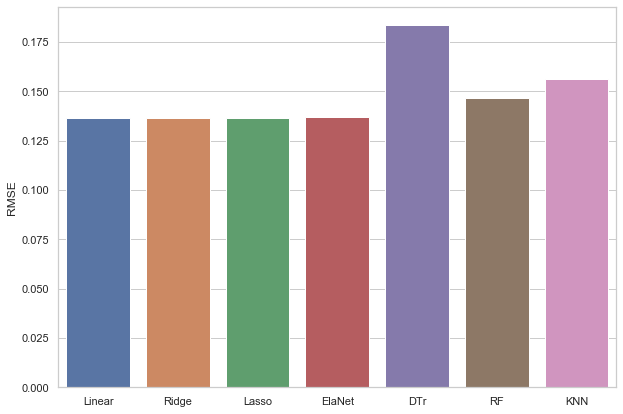

In [103]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

# Mean of best models

In [107]:
sub_mean = pd.DataFrame()
sub_mean['Id'] = id_test
sub_mean['SalePrice'] = np.round( (pred_lasso + pred_enet + pred_rf ) / 3.0 ) 
sub_mean['SalePrice'] = sub_mean['SalePrice'].astype(float)
# sub_mean.to_csv('mean.csv',index=False)

In [108]:
sub_mean.head(2)

,Id,SalePrice
0,1461,12.0
1,1462,12.0


# ADD - # Evaluation Table for regression

In [ ]:
# R-sqared 값이 1에 가까울 수록
# RMSE가 작을수록 좋은 모형
evaluation = pd.DataFrame({'Model':[],
                          'Details':[],
                          'Root Mean Squared Error (RMSE)':[],
                          'R-squared (training)':[],
                          'Adjusted R-squared (training)':[],
                          'R-squared (test)':[],
                          'Adjusted R-squared (test)':[],
                          '5-Fold Cross Validation':[]})

In [ ]:
# Ridge
pred2 = complex_model_R.predict(test_data_dm[features])
rmsecm2 = float(format(np.sqrt(metrics.mean_squared_error(test_data_dm['price'],pred2)),'.3f'))
rtrcm2 = float(format(complex_model_R.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrcm2 = float(format(adjustedR2(complex_model_R.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rtecm2 = float(format(complex_model_R.score(test_data_dm[features],test_data_dm['price']),'.3f'))
artecm2 = float(format(adjustedR2(complex_model_R.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv2 = float(format(cross_val_score(complex_model_R,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

In [ ]:
# KNN
rmseknn1 = float(format(np.sqrt(metrics.mean_squared_error(y_test,pred)),'.3f'))
rtrknn1 = float(format(knnreg.score(train_data_dm[features],train_data_dm['price']),'.3f'))
artrknn1 = float(format(adjustedR2(knnreg.score(train_data_dm[features],train_data_dm['price']),train_data_dm.shape[0],len(features)),'.3f'))
rteknn1 = float(format(knnreg.score(test_data_dm[features],test_data_dm['price']),'.3f'))
arteknn1 = float(format(adjustedR2(knnreg.score(test_data_dm[features],test_data_dm['price']),test_data_dm.shape[0],len(features)),'.3f'))
cv1 = float(format(cross_val_score(knnreg,df_dm[features],df_dm['price'],cv=5).mean(),'.3f'))

In [ ]:
evaluation.loc[r] = ['KNN Regression','k=15, all features',rmseknn1,rtrknn1,artrknn1,rteknn1,arteknn1,cv1]